# Canopy Wave demo

## Setup

### Configuration

The configuration below reflects the Jupyter + Docker setup and should be adapted to the user environment.

In [1]:
# Enable module autoreload
%load_ext autoreload
%autoreload 2

# Directories
script_dir = '/home/jovyan/work'
data_dir = '/home/jovyan/work/resources'

### Imports

In [72]:
# Standard
import datetime
import json
import os.path
import sys

# Third-party
import matplotlib.patches as patches  # To plot shapes
import matplotlib.pyplot as plt  # Main plotting module
import numpy as np  # Maths stuff

# Custom
sys.path.append(script_dir)  # Path to the canopywave scripts
import canopywaves as cw

## Create a CanopyWaveCase

Here we assume that a JSON file containing all necessary info to create the cases is available.

In [9]:
# Load JSON data
json_file = os.path.join(data_dir, 'canopywave_cases.json')
with open(json_file, 'r') as f:
    json_data = json.load(f)
       
# Pick a case, get info from JSON data   
case_id = 11
json_id = str(case_id)  # In the JSON file, IDs are written as strings
case_start = datetime.datetime.strptime(
    json_data[json_id]['datetime_start'],
    '%Y-%m-%d %H:%M:%S',
    )
case_stop = datetime.datetime.strptime(
    json_data[json_id]['datetime_stop'],
    '%Y-%m-%d %H:%M:%S',
    )
case_bscans = [os.path.join(data_dir, 'bscans', s) for s in json_data[json_id]['bscans']]

# Create the CanopyWaveCase instance
wavecase = cw.CanopyWaveCase(case_id, case_start, case_stop, case_bscans)
print(wavecase)

CanopyWaveCase #11
	data: 2007-04-24 13:00:22 - 2007-04-24 13:02:11 UTC (10 scans)
	grid: [-200.0, 202.0]x[-1810.0, -1408.0] m^2 (201x201 pixel^2 @ 2.0 m/pixel)


## Loading and displaying scan data

### Load scans

Note: this can take some time when GPU-accelerated functions are not available.

In [15]:
wavecase.load_scan_data()

* (Case #11) Loading scan data
File /home/jovyan/work/resources/bscans/REAL.20070424_130032.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130043.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130054.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130105.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130116.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)
File /home/jovyan/work/resources/bscans/REAL.20070424_130126.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 record

### Compute global hard-target mask

This mask is computed using all scans from the sequence, based on a simple value threshold.

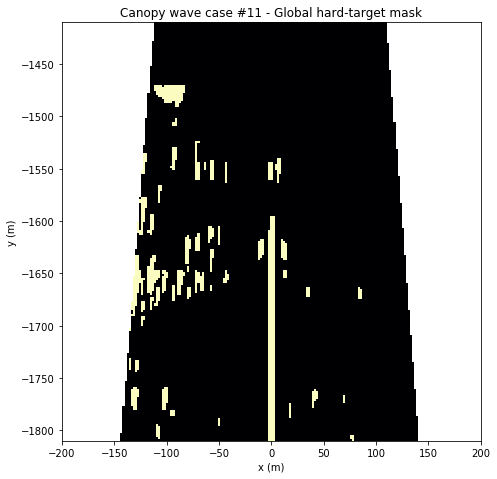

In [47]:
# Compute mask
hard_target_mask = wavecase.hard_target_mask(threshold=3.)

# Display
fig, ax = plt.subplots(figsize=(7.5, 8))
ax.imshow(
    np.ma.array(hard_target_mask, mask=wavecase.grid_global_mask),
    interpolation='nearest',
    cmap='magma',
    vmin=0,
    vmax=0.5,
    origin='bottom',
    extent=[wavecase.x[0], wavecase.x[-1], wavecase.y[0], wavecase.y[-1]],
    )
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title(f'Canopy wave case #{wavecase.case_id:02d} - Global hard-target mask')
plt.show()

### Display sample scan

We display both polar and cartesian data, the latter being masked by the hard-target mask computed above.

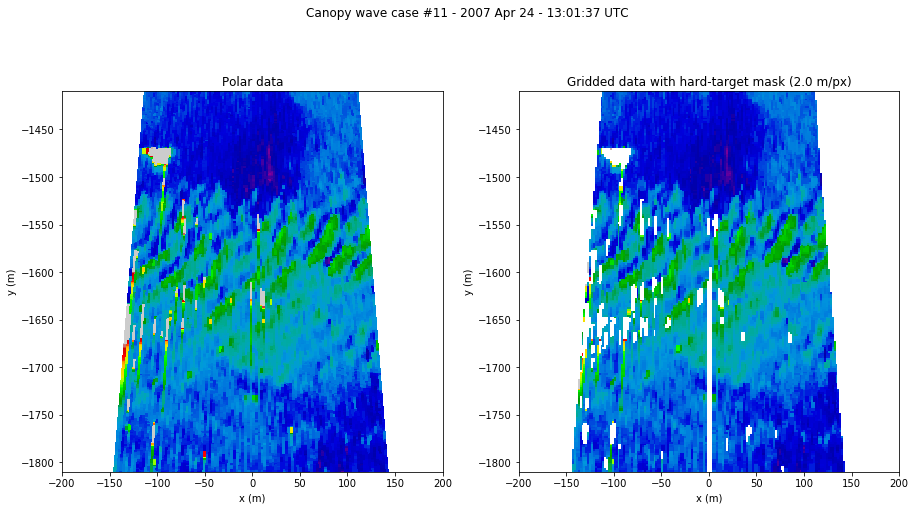

In [92]:
# Pick scan
scan_idx = 6
scan_data = wavecase.scan_data[scan_idx]  # Original (preprocessed) polar data
grid_scan = wavecase.grid_scans[scan_idx]  # Gridded data
grid_mask = wavecase.grid_masks[scan_idx]  # Grid mask
full_mask = np.logical_or(hard_target_mask, grid_mask)

# Create figure
fig, axes = plt.subplots(1,2, figsize=(15, 8))
axp, axc = axes  # Polar, Cartesian
# Polar data
axp.set_title('Polar data')
axp.set_aspect('equal')  # Force same scale on x, y axes
p0 = axp.pcolormesh(
    scan_data['x'],
    scan_data['y'],
    scan_data['scan'],
    cmap='nipy_spectral',
    vmin=-1,
    vmax=3
    )
# Gridded data
axc.set_title('Gridded data with hard-target mask ({} m/px)'.format(
    wavecase.param_grid["resolution"]))
p1 = axc.imshow(
    np.ma.array(grid_scan, mask=full_mask),
    interpolation='nearest',
    cmap='nipy_spectral',
    vmin=-1.,
    vmax=3.,
    origin='bottom',
    extent=[wavecase.x[0], wavecase.x[-1], wavecase.y[0], wavecase.y[-1]],
    )
# Tune axes
for ax in axes:
    ax.set_xlim(xmin=wavecase.x[0], xmax=wavecase.x[-1])
    ax.set_ylim(ymin=wavecase.y[0], ymax=wavecase.y[-1])
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
# Add global title
plt.figtext(
    0.5,
    0.98,
    'Canopy wave case #{:02d} - {:%Y %b %d - %H:%M:%S} UTC'.format(
        wavecase.case_id, scan_data['time'][0]),
    ha='center',
    va='top',
    size='large',
    )    
plt.show()


## Estimating wave parameters

### Compute autocorrelations

Autocorrelations are computed for each scan in the frequency domain through an FFT. A 2D Hann tapering window is applied to the scan before to the FFT to avoid side effects.

_Note: this may take some time on the first run._

In [63]:
# Compute autocorrelations
autocorrelations, (xlag, ylag) = wavecase.autocorrelations()

### Estimate parameters

For each scan, a single set of **wavelength and crest orientation** parameters is estimated from the autocorrelation function. This is done by looping at peaks of the isotropic and directional spectra, respectively.

In [67]:
# Estimate wave parameters (wavelength, crest orientation) for each scan,
# as well as the "mean" wave (across scans)
waves, mean_wave = wavecase.wave_parameters()
for idx, wave in enumerate(waves):
    print('[{idx}] Wavelength: {wavelength:.1f} m, crest orientation: {crest_direction:.0f} deg'.format(
        idx=idx, **wave))

[0] Wavelength: 21.0 m, crest orientation: 37 deg
[1] Wavelength: 23.0 m, crest orientation: 38 deg
[2] Wavelength: 25.0 m, crest orientation: 40 deg
[3] Wavelength: 23.0 m, crest orientation: 39 deg
[4] Wavelength: 23.0 m, crest orientation: 37 deg
[5] Wavelength: 23.0 m, crest orientation: 37 deg
[6] Wavelength: 25.0 m, crest orientation: 36 deg
[7] Wavelength: 25.0 m, crest orientation: 37 deg
[8] Wavelength: 25.0 m, crest orientation: 35 deg
[9] Wavelength: 27.0 m, crest orientation: 34 deg


### Display autocorrelation and wave parameters

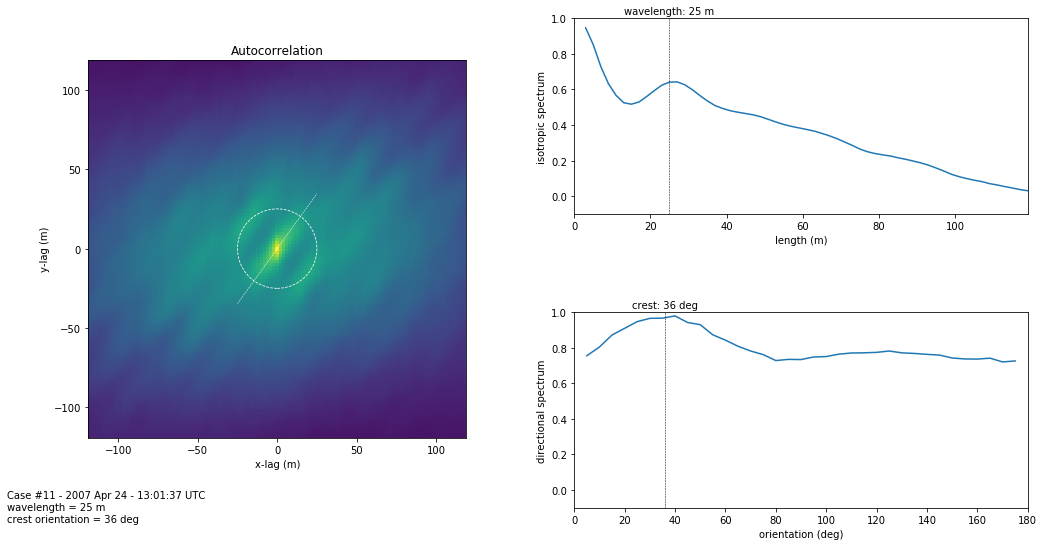

In [93]:
# Wave info for the same scan as the one displayed above
wavelength = waves[scan_idx]['wavelength']
crest_orientation = waves[scan_idx]['crest_direction']
max_radius = waves[scan_idx]['radii'][-1]
# Create figure
fig, axes_spec = plt.subplots(
    2, 1,
    figsize=(15, 8),
    gridspec_kw={
        'left':.55,
        'right':.97,
        'bottom':.1,
        'top':.95,
        'hspace':.5,
        },
    )
# Auto-correlation
ax_corr = fig.add_axes([.1, .1, .35, .9])
ax_corr.set_title('Autocorrelation')
p = ax_corr.imshow(
    autocorrelations[scan_idx],
    interpolation='nearest',
    origin='bottom',
    extent=[xlag[0,0], xlag[0,-1], ylag[0,0], ylag[-1,0]])
ax_corr.set_xlim(-max_radius, max_radius)
ax_corr.set_ylim(-max_radius, max_radius)
ax_corr.set_xlabel('x-lag (m)')
ax_corr.set_ylabel('y-lag (m)')
# Isotropic spectrum
ax = axes_spec[0]
ax.set_xlim(0., max_radius)
ax.set_ylim(-0.1, 1.)
ax.set_xlabel('length (m)')
ax.set_ylabel('isotropic spectrum')
ax.plot(waves[scan_idx]['radii'], waves[scan_idx]['iso_spectrum'])
if wavelength is not np.nan:
    # Plot wavelength on isotropci spectrum as a vertical dashed line
    ax.axvline(wavelength, ls='--', color='k' ,lw=0.5)
    ax.text(wavelength, 1.01, 'wavelength: {:.0f} m'.format(wavelength),
            ha='center', va='bottom', transform=ax.get_xaxis_transform())
    # Plot wavelength on autocorrelation as a white dashed circle
    ax_corr.add_artist(patches.Circle(
        (0., 0.),
        radius=wavelength,
        ls='--',
        fc='none',
        ec='w',
        lw=0.75,
        ))
# Directional spectrum
ax = axes_spec[1]
ax.set_xlim(0., 180.)
ax.set_ylim(-0.1, 1.)
ax.set_xlabel('orientation (deg)')
ax.set_ylabel('directional spectrum')
ax.plot(waves[scan_idx]['directions'], waves[scan_idx]['dir_spectrum'])
if crest_orientation is not None:
    # Plot orientation on isotropic spectrum as a vertical dashed line
    ax.axvline(crest_orientation, ls='--', color='k', lw=0.5)
    ax.text(crest_orientation, 1.01, 'crest: {:.0f} deg'.format(crest_orientation),
            ha='center', va='bottom', transform=ax.get_xaxis_transform())
    # Plot on autocorr as a dashed line
    if crest_orientation is not np.nan:
        if crest_orientation>0.:
            slope = 1./np.tan(np.deg2rad(crest_orientation))
            x0 = -wavelength
            y0 = slope*x0
            x1 = wavelength
            y1 = slope*x1
        else:
            x0 = 0.
            y0 = -wavelength
            x1 = 0.
            y1 = wavelength
        ax_corr.plot([x0, x1], [y0, y1], color='w', ls='--', lw=0.5)
# Labels
wavelength_str = ('{:.0f} m'.format(wavelength) if
                  (wavelength is not None) else 'not found' )
orientation_str = ('{:.0f} deg'.format(crest_orientation) if
                   (propagation_direction is not None) else 'not found')
plt.figtext(
    0.025,
    0.13,
    'Case #{:02d} - {:%Y %b %d - %H:%M:%S} UTC\nwavelength = {}\ncrest orientation = {}'.format(
        wavecase.case_id, wavecase.scan_data[scan_idx]['time'][0], wavelength_str, orientation_str),
    ha='left',
    va='top',
    size='medium',
    color='k',
    )
plt.show()

### Fix outliers

Sometimes the estimation fails. This step finds and fixes outliers by replacing them with the parameters estimated for the mean wave.

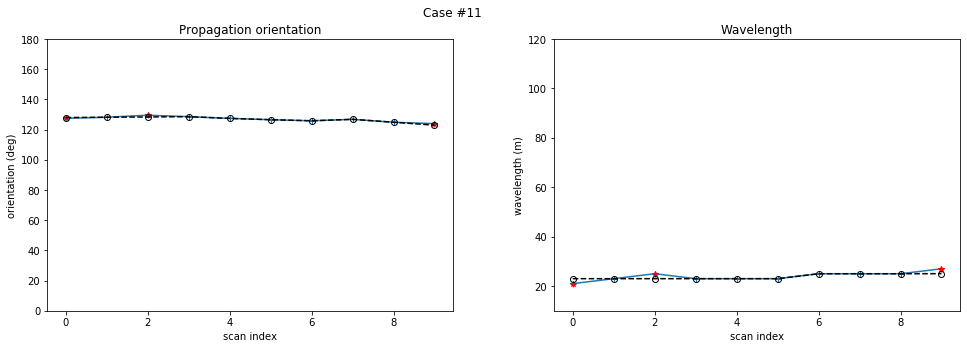

In [99]:
# Fix outliers
wavelengths_fixed, directions_fixed, is_fixed = wavecase.fix_wave_outliers(waves, mean_wave)
        
# Display
# Extract estimated wavelength, directions (excluding mean wave)
wavelengths_estimated = np.array([wave['wavelength'] if (wave is not None)
                                  else numpy.nan for wave in waves])
directions_estimated = np.array([wave['propagation_direction'] if (wave is not None)
                                 else numpy.nan for wave in waves])
idx = np.arange(len(waves))
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'right':.97, 'wspace':.25})
axes[0].plot(idx, directions_estimated, '+-')
axes[0].plot(idx[is_fixed], directions_estimated[is_fixed], '*r')
axes[0].plot(idx, directions_fixed, 'o--k', markerfacecolor='none')
axes[0].set_ylim(0., 180.)
axes[0].set_xlabel('scan index')
axes[0].set_ylabel('orientation (deg)')
axes[0].set_title('Propagation orientation')
axes[1].plot(idx, wavelengths_estimated, '+-')
axes[1].plot(idx[is_fixed], wavelengths_estimated[is_fixed], '*r')
axes[1].plot(idx, wavelengths_fixed, 'o--k', markerfacecolor='none')
axes[1].set_ylim(10., 120.)
axes[1].set_xlabel('scan index')
axes[1].set_ylabel('wavelength (m)')
axes[1].set_title('Wavelength')
plt.figtext(0.5, 0.97, 'Case #{:02d}'.format(wavecase.case_id), ha='center', va='top', size='large')
plt.show()

## Locating wave crests

### Synthetic wave profiles

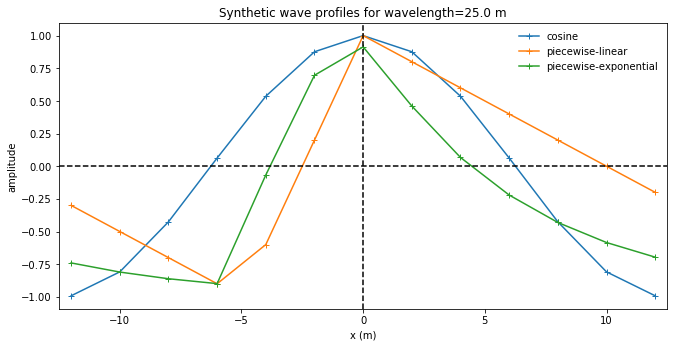

In [110]:
# Wave parameters
wavelength = 25.  # Wavelength in [m]
resolution = 2.  # [m/px]
# Grid
n = np.int(np.ceil(wavelength/resolution))
if not n%2:  # Ensure an odd number of points
    n += 1
x = resolution*(np.arange(n) - float(n//2))  # Center the crest at x=0.
# Compute profiles
y_lin = cw.CanopyWaveCase.breaking_wave_linear(x, wavelength)  # Asymmetric, piecewise-linear model
y_exp = cw.CanopyWaveCase.breaking_wave_exp(x, wavelength)  # Asymmetric, piecewise-exponential model
y_wav = cw.CanopyWaveCase.symmetric_wave_cos(x, wavelength)  # Symmetric, cosine model
# Plot
fig, ax = plt.subplots(figsize=(10, 5), gridspec_kw={'right':0.97, 'top':.92})
ax.plot(x, y_wav, '+-', label='cosine')
ax.plot(x, y_lin, '+-', label='piecewise-linear')
ax.plot(x, y_exp, '+-', label='piecewise-exponential')
ax.axhline(0., color='k', ls='--', label='_nolabel_')
ax.axvline(0., color='k', ls='--', label='_nolabel_')
ax.set_xlim(-wavelength/2., wavelength/2.)
ax.set_xlabel('x (m)')
ax.set_ylabel('amplitude')
ax.set_title('Synthetic wave profiles for wavelength={} m'.format(wavelength))
ax.legend(frameon=False)
plt.show()